In [173]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
pio.renderers.default = 'notebook'
sns.set_palette('bright')

pd.set_option('display.max_rows', 30)

sns.set_context(rc={"font.size":8,"axes.titlesize":10,"axes.labelsize":8}) 
%config InlineBackend.figure_format = 'retina'

загрузим очищенный датасет

In [174]:
df = pd.read_csv('clear_dataset.csv', index_col=0)
df.head()

,title,year,age,run,history,owners_pts,modification,volume,engine_type,transmission,...,exchange,mark,accident,other_history,tech_history,sold,subway,pts_type,price,horse_power
0,Kia K900 3.3 AT,2019,II,91037,8.0,2,3.3 4WD AT,3.3,Бензин,Автомат,...,Возможен,соответствует,1,2,4,1,Аннино:6–10 мин.;Лесопарковая:11–15 мин.;Улица...,Другое,2999000,249
1,Mercedes-Benz V-класс 2.1 AT,2017,W447,95250,19.0,2,V 250 d 2.1 4MATIC AT L3,2.1,Дизель,Автомат,...,Не интересует,соответствует,0,0,19,0,Проспект Вернадского:до 5 мин.;Новаторская:16–...,Оригинал,5650000,190
2,Opel Astra GTC 1.4 AT,2013,J рестайлинг,113000,6.0,2,1.4 Turbo AT,1.4,Бензин,Автомат,...,Возможен,ниже,1,0,0,3,Южная:11–15 мин.;Чертановская:21–30 мин.;Пражс...,Другое,699000,140
3,Volkswagen Tiguan 2.0 AT,2015,I рестайлинг,165000,9.0,2,2.0 TDI 4Motion AT,2.0,Дизель,Автомат,...,Возможен,ниже,0,2,5,1,Волоколамская:16–20 мин.;Мякинино:от 31 мин.;Т...,Другое,1195000,140
4,Ford Kuga 1.5 AT,2018,II рестайлинг,103000,16.0,1,1.5 EcoBoost 4WD AT,1.5,Бензин,Автомат,...,другое,соответствует,0,1,10,1,Ховрино:до 5 мин.;Беломорская:21–30 мин.;Речно...,Оригинал,1780000,150


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 0 to 1697
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1698 non-null   object 
 1   year           1698 non-null   int64  
 2   age            1698 non-null   object 
 3   run            1698 non-null   int64  
 4   history        1698 non-null   float64
 5   owners_pts     1698 non-null   object 
 6   modification   1698 non-null   object 
 7   volume         1698 non-null   float64
 8   engine_type    1698 non-null   object 
 9   transmission   1698 non-null   object 
 10  gear           1698 non-null   object 
 11  body           1698 non-null   object 
 12  color          1698 non-null   object 
 13  wheel          1698 non-null   object 
 14  exchange       1698 non-null   object 
 15  mark           1698 non-null   object 
 16  accident       1698 non-null   int64  
 17  other_history  1698 non-null   int64  
 18  tech_history 

Большинство переменных в нашем датасете являются категориальными, однако есть несколько числовых переменных. Рассмотрим распределение числовых и категориальных признаков, чтобы лучше понимать соотношение категорий и значений

In [176]:

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = df.select_dtypes(include=['object']).columns.to_list()


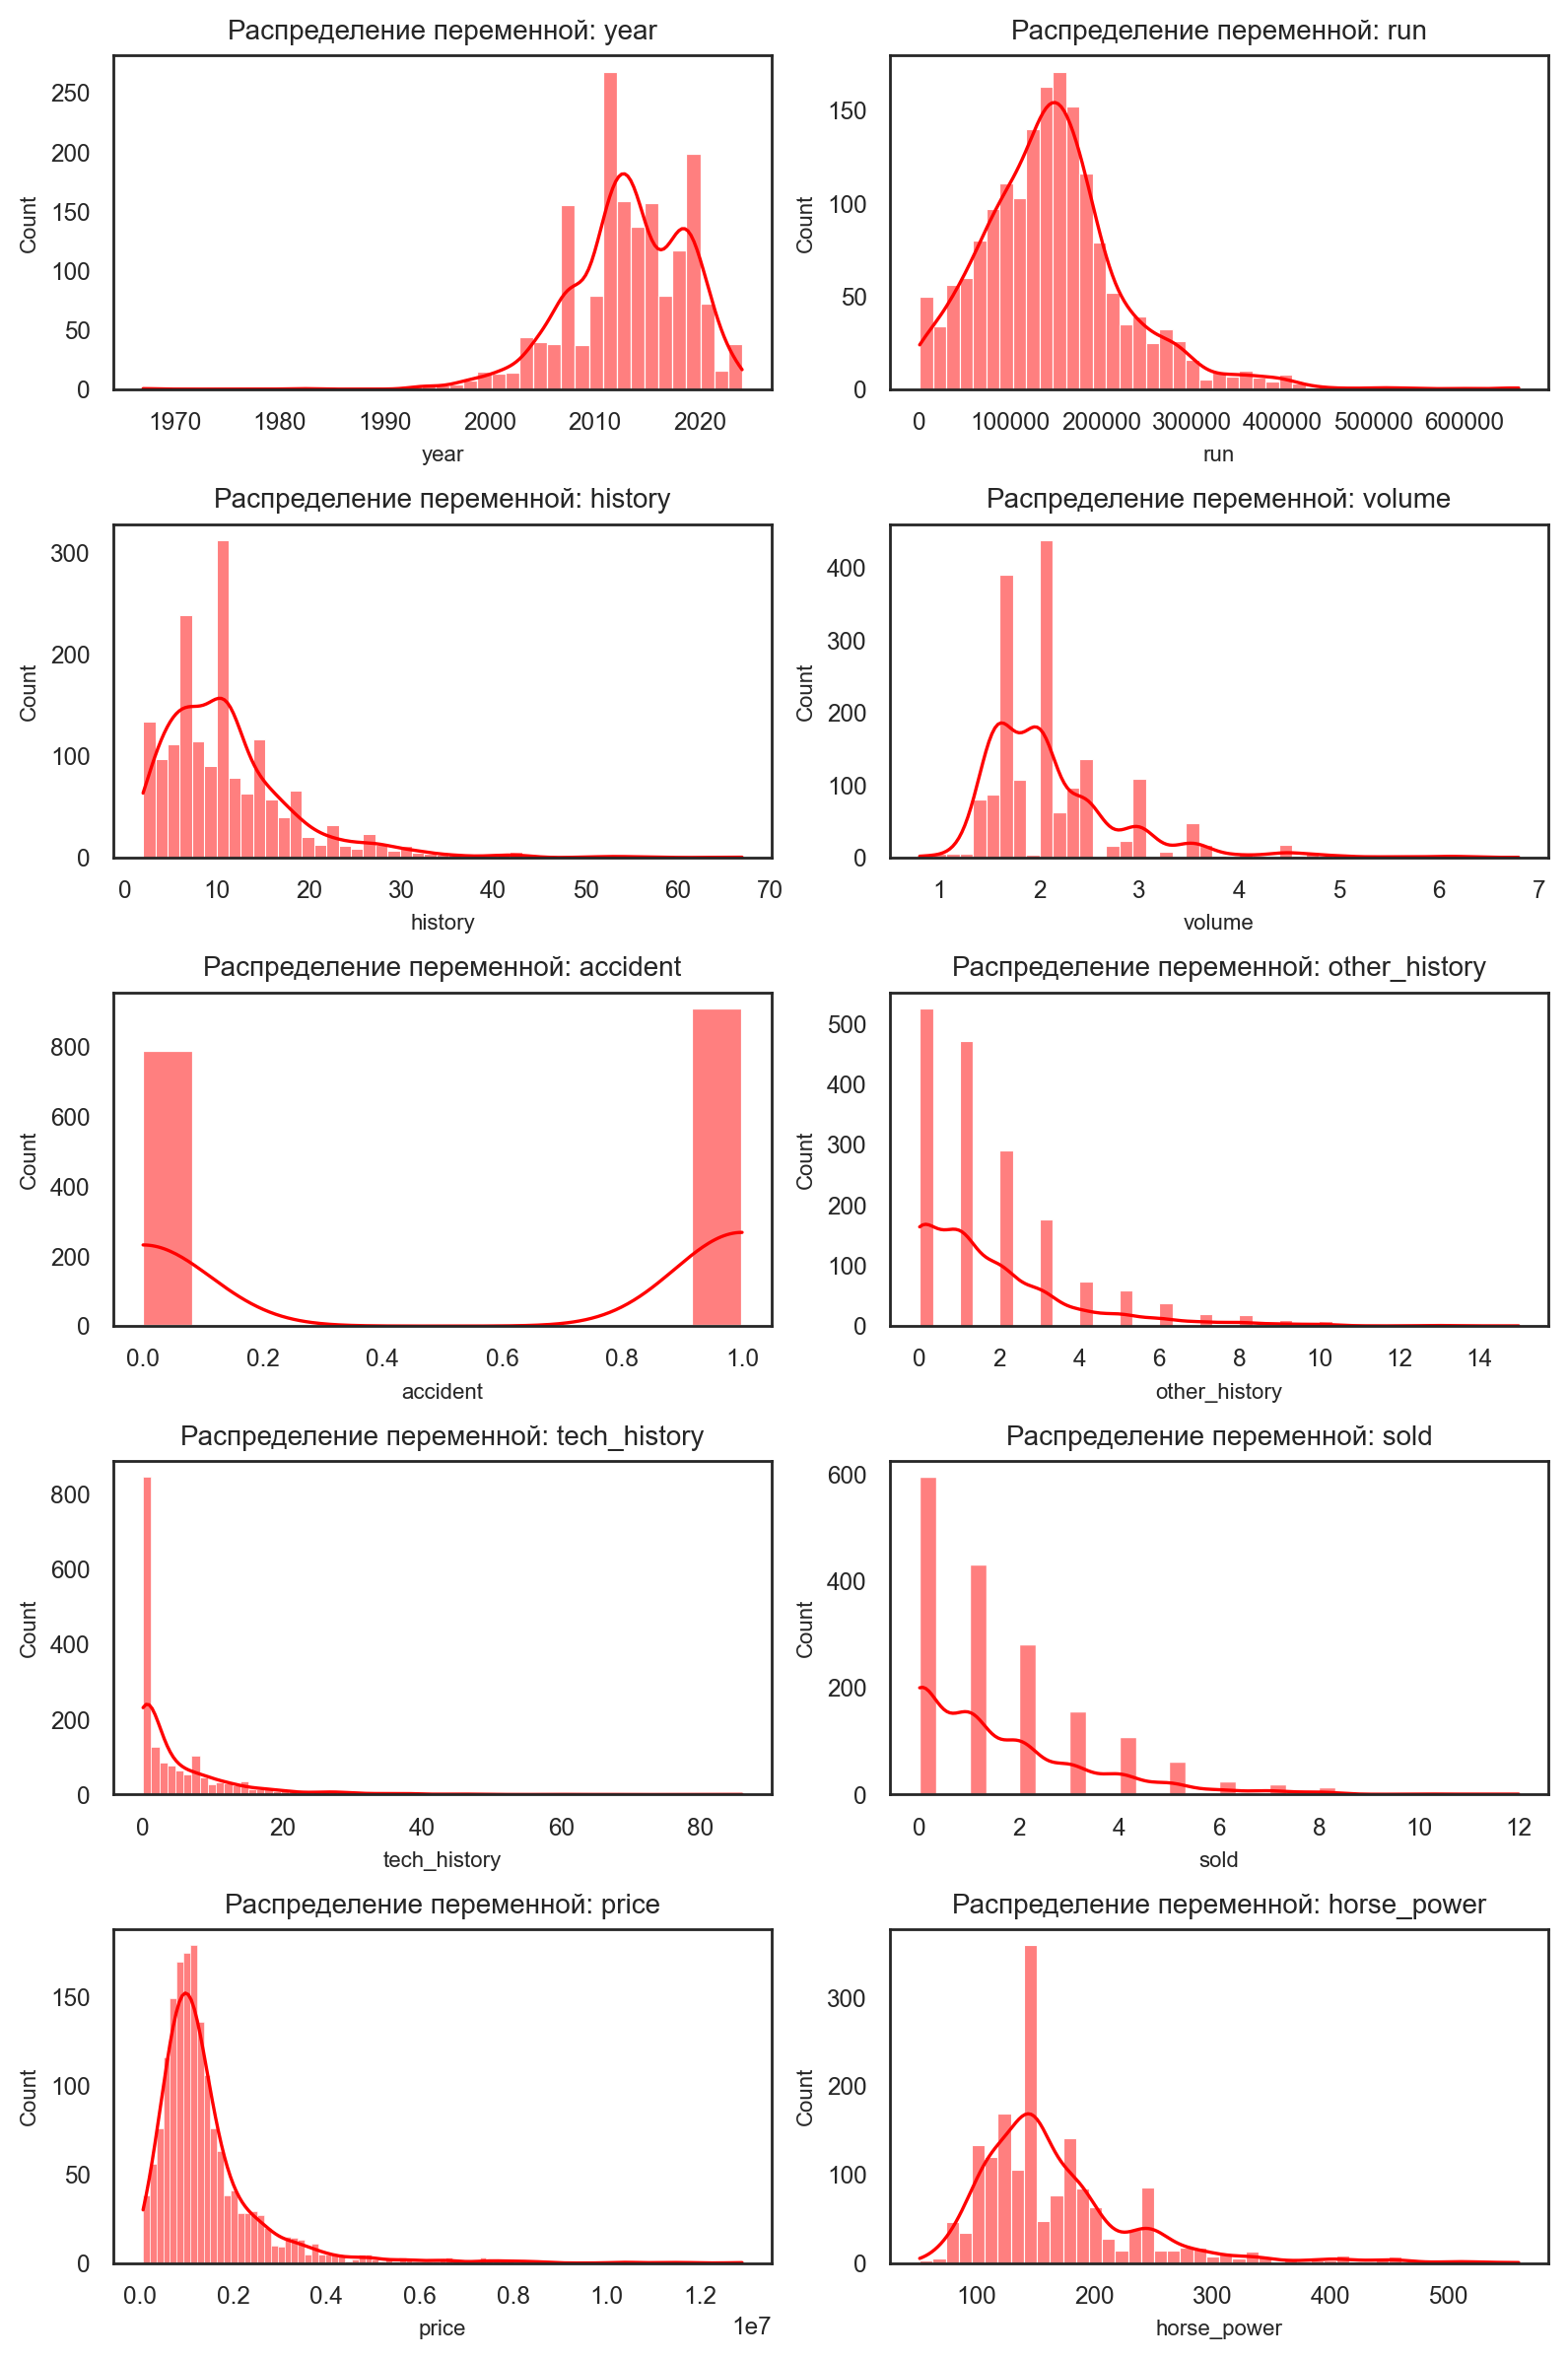

In [177]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='red') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='both')
    

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

а также посмотрим на статистики данных признаков:

In [178]:
df.describe()

,year,run,history,volume,accident,other_history,tech_history,sold,price,horse_power
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1.698000e+03,1698.000000
mean,2013.157833,147104.740872,11.244405,2.141281,0.535925,1.738516,5.018846,1.573027,1.450681e+06,168.058304
std,5.579326,80746.798570,7.497616,0.737547,0.498855,2.048599,8.150521,1.816159,1.240806e+06,69.097922
min,1967.000000,1.000000,2.000000,0.800000,0.000000,0.000000,0.000000,0.000000,7.300000e+04,52.000000
25%,2010.000000,96000.000000,6.000000,1.600000,0.000000,0.000000,0.000000,0.000000,7.850000e+05,123.000000
50%,2013.000000,142383.500000,10.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.125500e+06,150.000000
75%,2018.000000,183768.250000,14.000000,2.400000,1.000000,2.000000,7.000000,2.000000,1.650000e+06,190.000000
max,2024.000000,660000.000000,67.000000,6.800000,1.000000,15.000000,86.000000,12.000000,1.290000e+07,560.000000


- Видим, что в переменная года выпуска распределена достаточно неравномерно и присутствуют выбросы до 2000х годов, но основные значения распределены от 2010 до 2018.
- Пробег распределен более равномерно, хоть и присутствует перекос влево, как и у переменных истории пробега, количества лошадиных сил и цены. 
- Объем двигателя распределен менее равномерно и с перекосом влево, и большинство значений распределено около 2х
- Число записей о техобслуживании (что можно отнести в категориальный признак) имеет большое число выбросов и выделяющуюся категорию около 10 => требуется отдельно рассмотреть релевантность использования данной переменной

*Категориальные признаки*
- Налиие или отсутвие информации о ДТП (accident) распределена приблизительно равномерно
- other_history – история владельцев - имеет несколько мелких категорий на числе владельцев больше 6
- Число продаж имеет самое частое значение – 2, однако значения меньше 6 также встречаются часто. В целом число продаж на авито и число предыдущех владельцев распределены примрено одинаково (есть отличие около 5-6 владельцев/продаж), из чего можем сделать предположение о том что практически всегда машины, продающиеся на авито несколько раз имеют нескольких владельцев-пользователей Авито


Сделаем то же самое для категориальных признаков, но не будем брать в расчет название (title), age (поколение) и modification – модификация автомобиля, так как в данных признаках слишком много значений и мы рассмотрим их отдельно

In [181]:
cat_cols_display = [i for i in cat_cols if i not in ['title', 'age', 'modification', 'subway']]

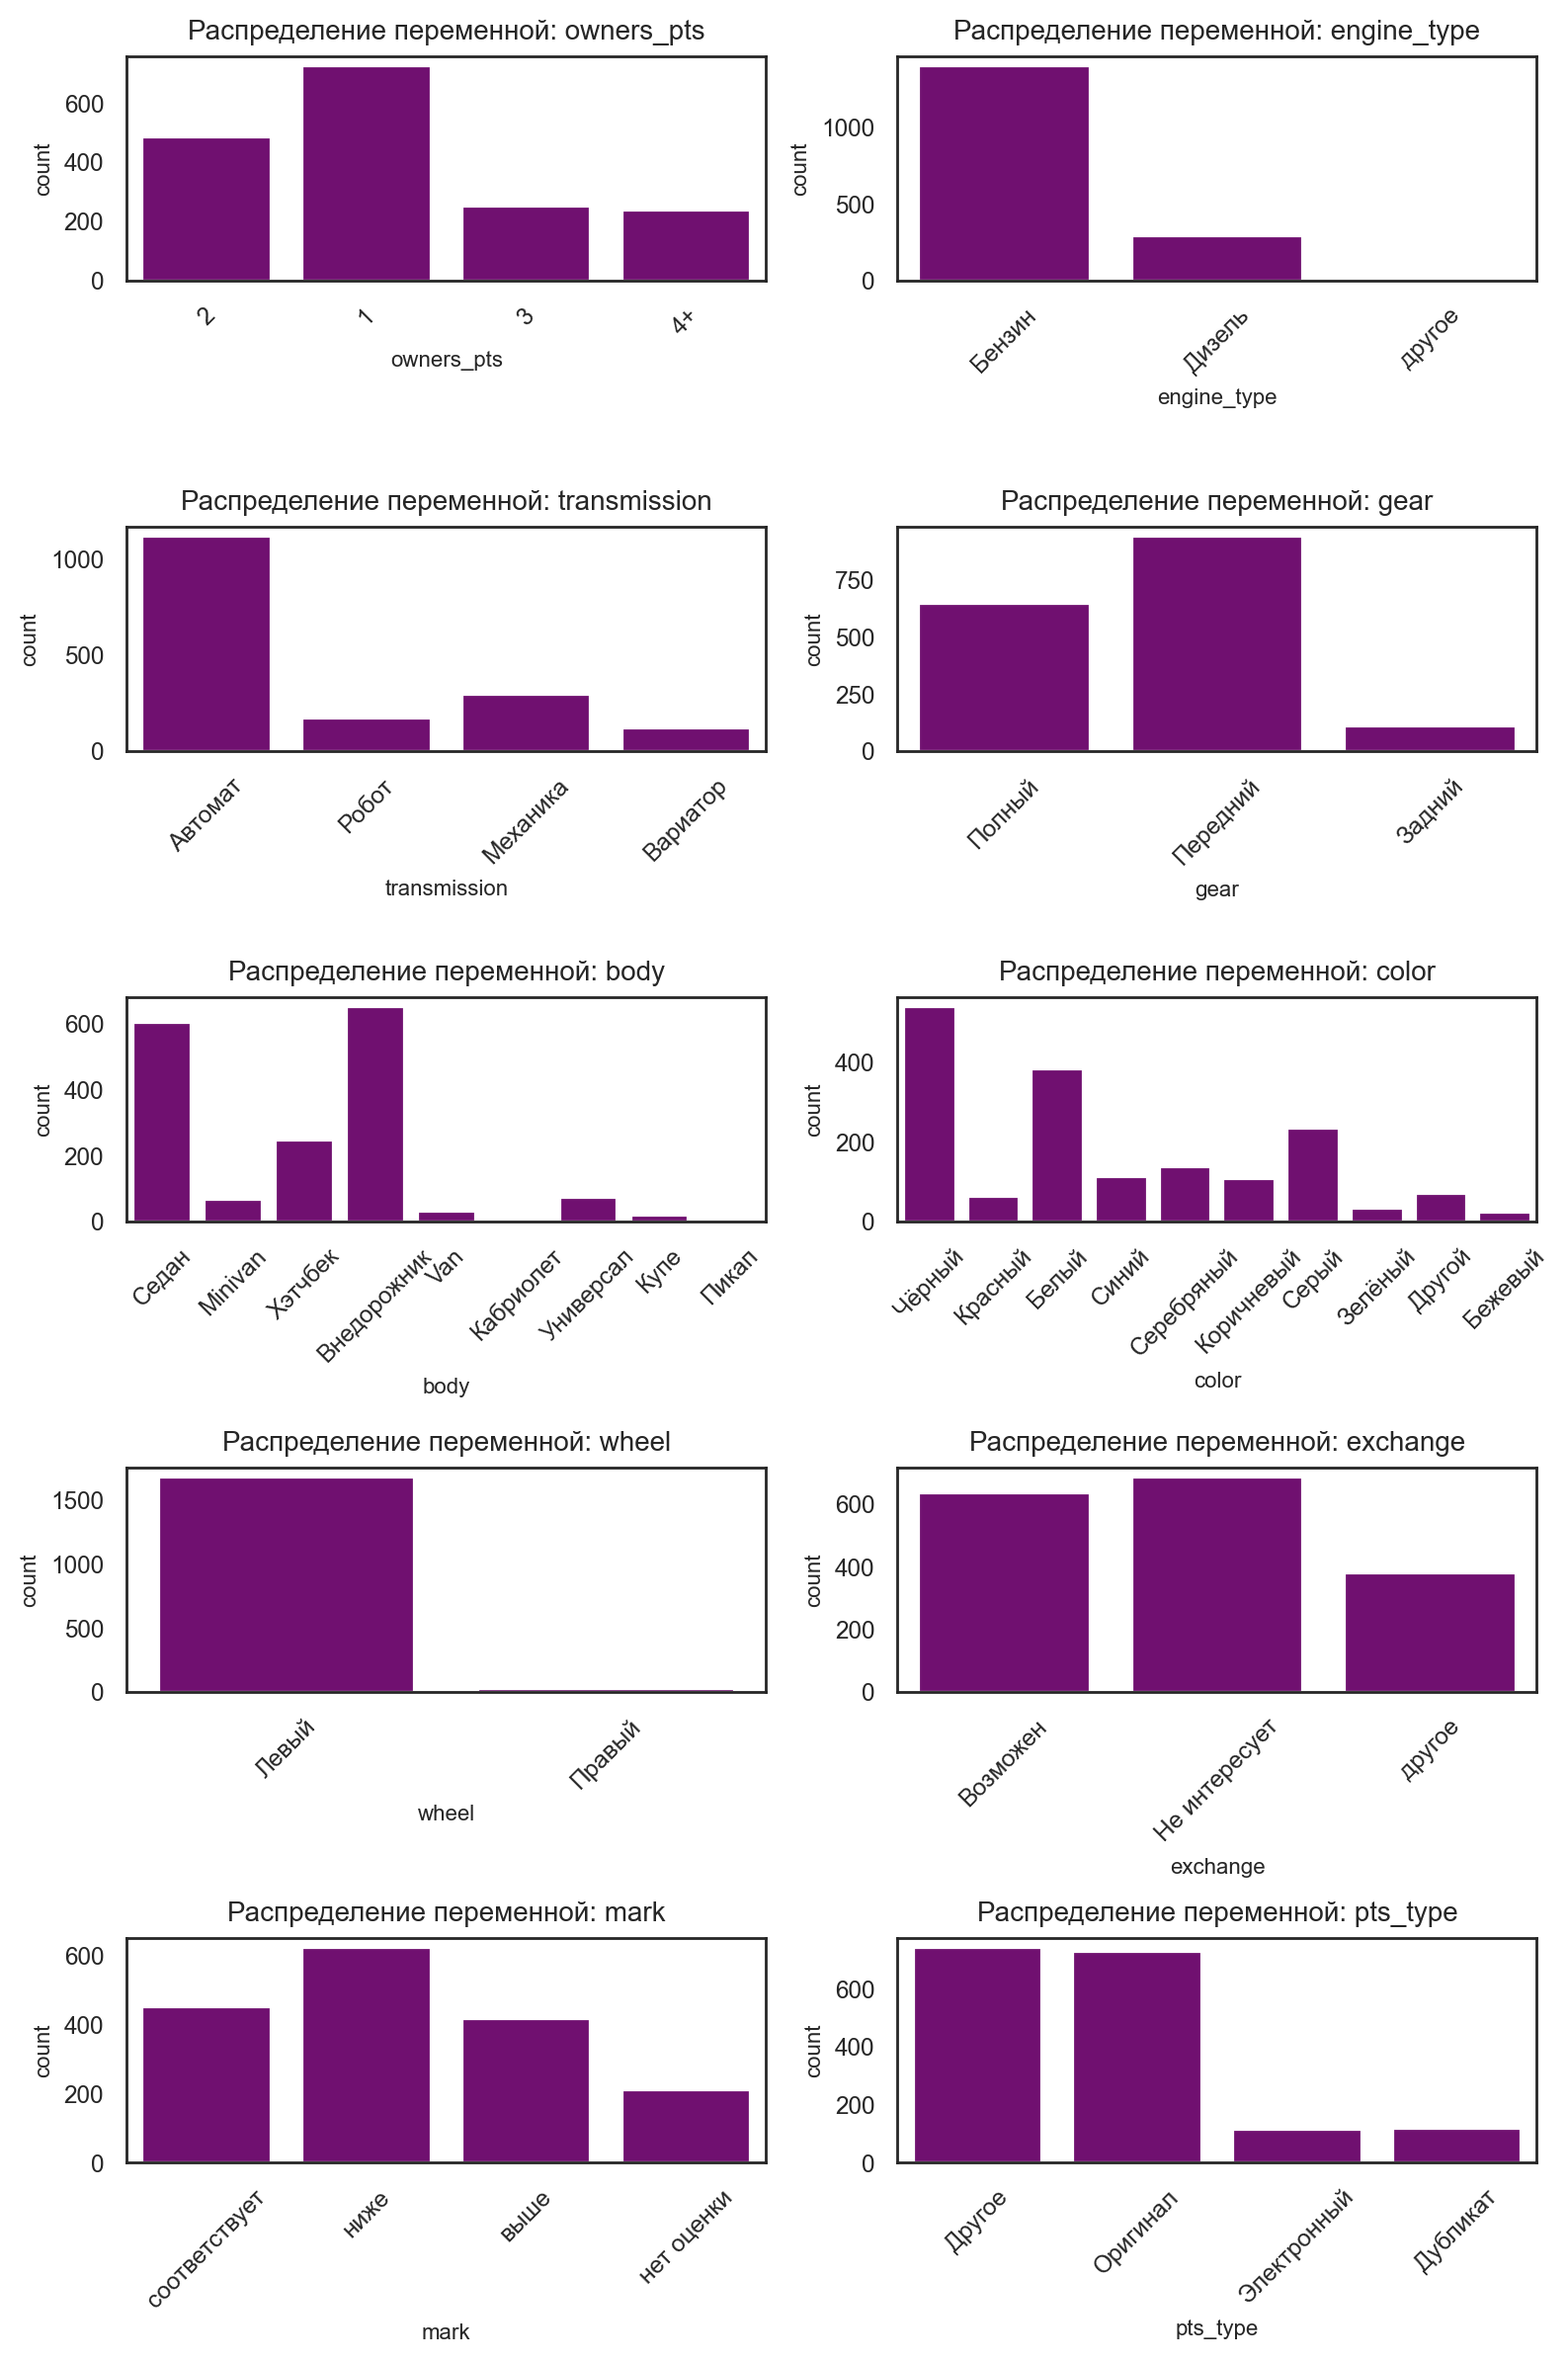

In [182]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(cat_cols_display):
    sns.countplot(data=df, x=col, ax=axes[i], color='purple') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='x', labelrotation=45)
    

plt.tight_layout()
plt.show()

In [183]:
df.describe(include='object')


,title,age,owners_pts,modification,engine_type,transmission,gear,body,color,wheel,exchange,mark,subway,pts_type
count,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1675,1698
unique,638,227,4,401,3,4,3,9,10,2,3,4,518,4
top,Kia Sportage 2.0 AT,I,1,1.6 AT,Бензин,Автомат,Передний,Внедорожник,Чёрный,Левый,Не интересует,ниже,Аннино:6–10 мин.;Лесопарковая:11–15 мин.;Улица...,Другое
freq,47,301,723,153,1394,1115,940,650,536,1676,684,622,73,740


В категориальныых признаках есть признаки отвечающий за тип руля, который разделен очень неравномерно, и engine_type, очень маленьким числом значений, попадающим в категорию другое. Переведем тип руля в бинарный признак, а тип бензина из категории другое переведем в бинарный признак

In [184]:
df['wheel'] = df['wheel'].map({'Правый': 0, 'Левый': 1}).astype(int)
df['engine_type'] = df['engine_type'].map({'другое':0, 'Бензин': 0, 'Дизель': 1}).astype(int)

Для окончания общего анализа перемнных, построим матрецу корреляций между переменными и ценой. Однако сначала посмотрим сгладится ли распределение цены при применении функции логарифма к ней.

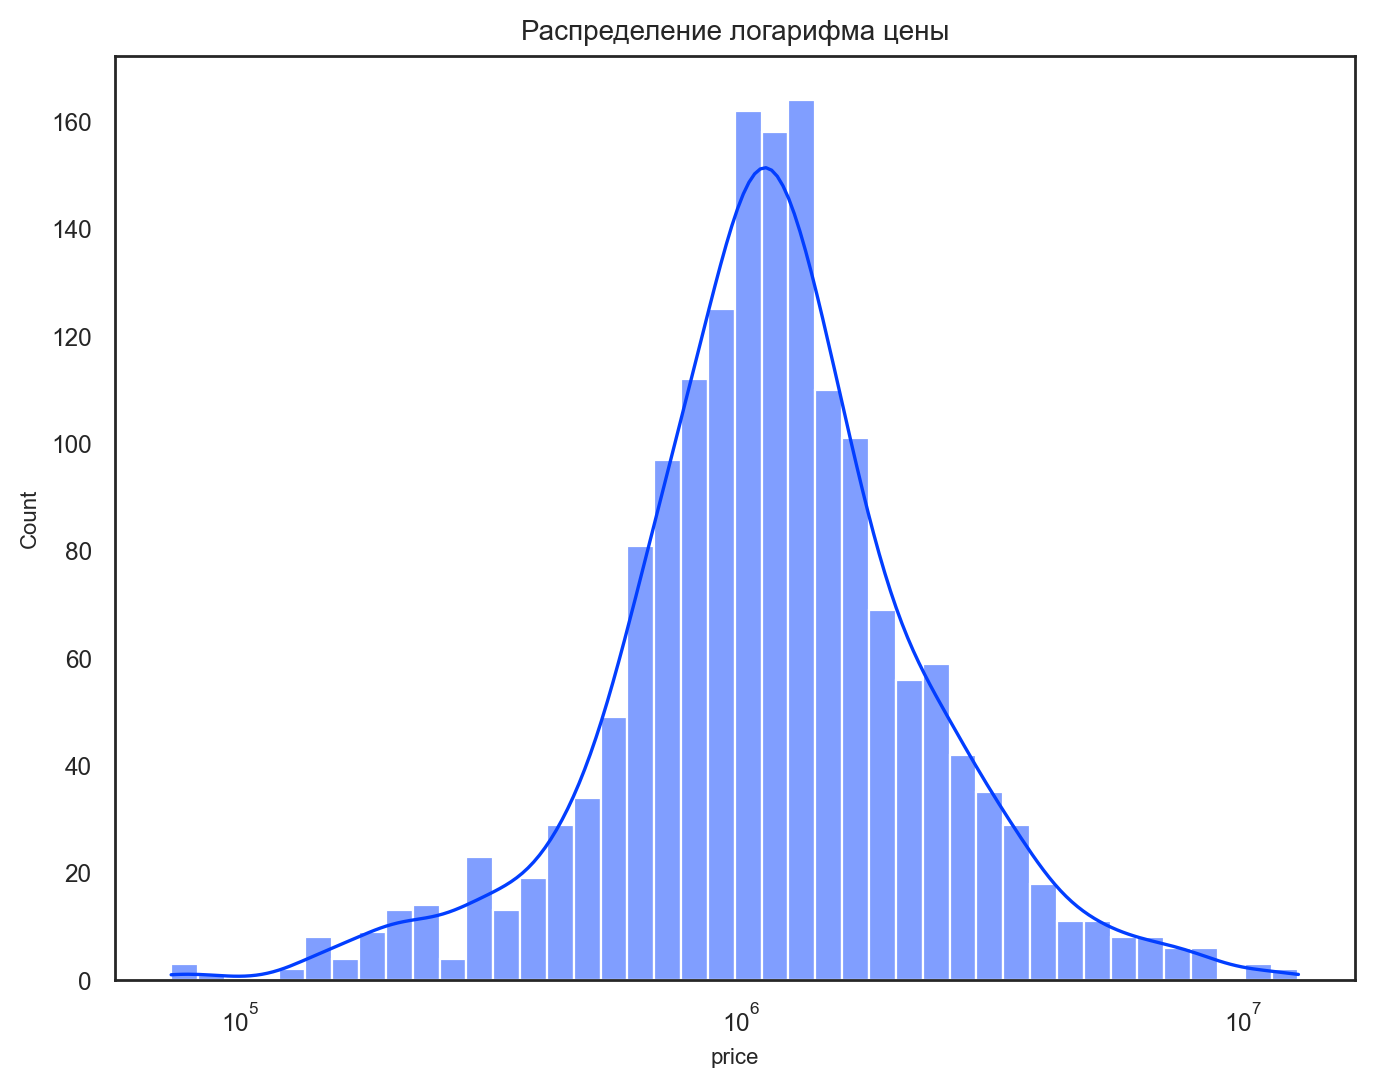

In [185]:
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], kde=True, log_scale=True) 
plt.title(f'Распределение логарифма цены') 
plt.show()

Видим, что значение сгладилось, а значит его использование вдальнейшем будет лучше для анализа

In [186]:
df['price_log'] = np.log(df['price'] + 1)
num_cols = df.select_dtypes([int, float]).columns.to_list()

In [187]:
num_cols

['year',
 'run',
 'history',
 'volume',
 'engine_type',
 'wheel',
 'accident',
 'other_history',
 'tech_history',
 'sold',
 'price',
 'horse_power',
 'price_log']

Для окончания общего анализа и перехода к более конкретным переменным и зависимости между ними, построем корреляционную матрицу

<Axes: >

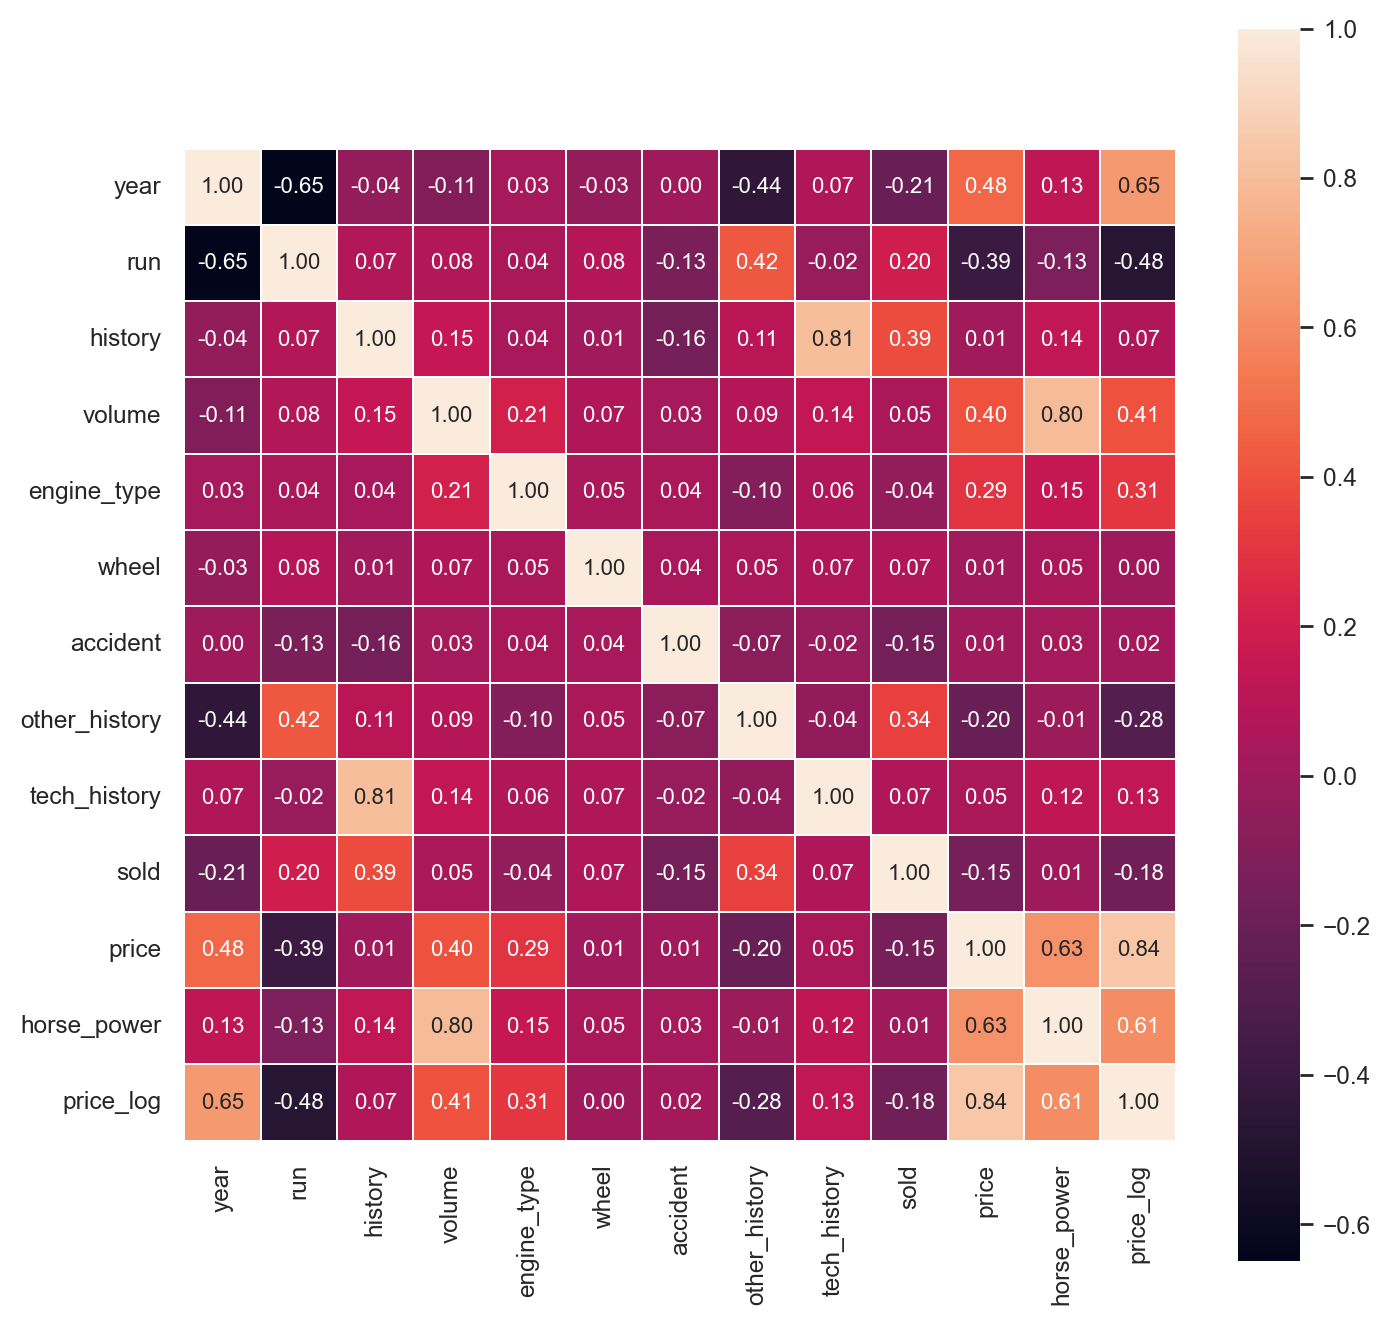

In [188]:
plt.figure(figsize=(8, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, square=True, annot=True, fmt='.2f', linewidths=0.15)

Из анализа матрицы корреляций видим, что тип руля (значение которого практически всегда принимает значение левый), наличие информации о ДТП и об истории пробега имеют практически нулевую корреляцию с целевой переменной, поэтому их можно выкинуть из дальнейшего анализа

In [189]:
df.drop(columns=['wheel', 'history', 'accident'], inplace=True)

Важным замечанием является то, что wheel и accident в целом слабо коррелируют со всеми другими переменными, однако есть значительная взаимосвязь с истории пробега с историей техобслуживания и количеством продаж машины на авито.

Сделаем основные выводы по коррелирующим с ценой переменной:
- Больше всего на цену влияет год выпуска и личество лошадиных сил (напрямую зависящий от объема двигателя).
- Обратное влияние на цену имеет пробег (то есть чем пробег ниже тем выше цена, что в целом достаточно логично)
- Число предыдущих владельцев (other history) немного отрицательно влияет на цену, как и число предыдущих продаж. 
- Что интересно, информация о техобслуживании не сильно, но положительно коррелирут с ценой, как и объем и тип двигателя


Так как число лошадиных сил, год выпуска и пробег являются исходно числовыми переменными, то можем визуализировать их взаимосвязь с ценой в ScatterPlot

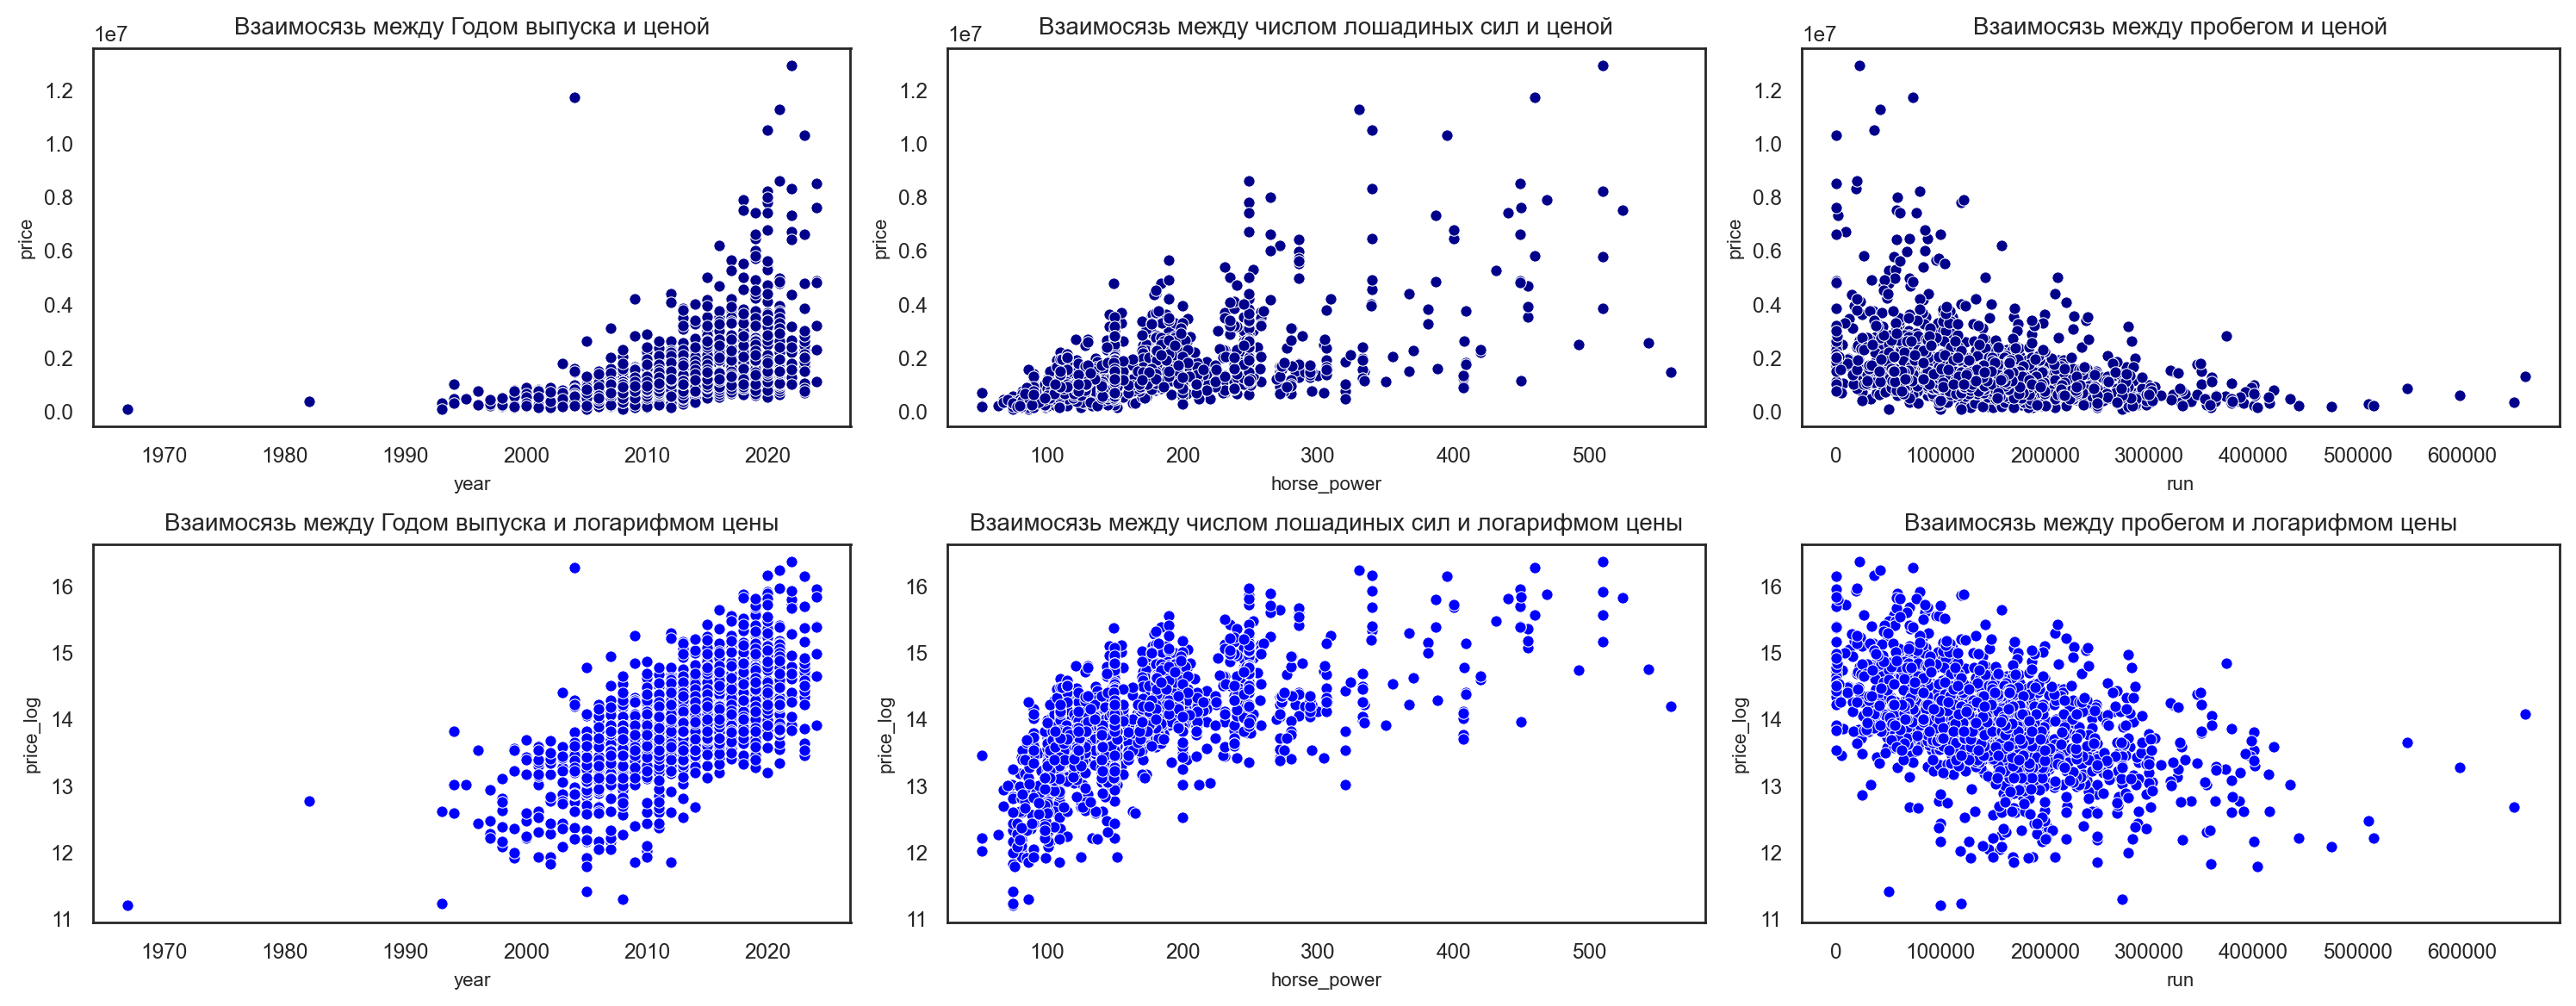

In [190]:
cols_analyse = ['year', 'horse_power', 'run']
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
translate_cols = {'year': 'Годом выпуска', 'horse_power': 'числом лошадиных сил', 'run':'пробегом'}

for i, col in enumerate(cols_analyse):
    sns.scatterplot(data=df, x=col, y='price', ax=axes[i], color='darkblue') 
    axes[i].set_title(f'Взаимосязь между {translate_cols[col]} и ценой')

for i, col in enumerate(cols_analyse):
    sns.scatterplot(data=df, x=col, y='price_log', ax=axes[i+3], color='blue') 
    axes[i + 3].set_title(f'Взаимосязь между {translate_cols[col]} и логарифмом цены')


plt.tight_layout()
plt.show()


Забавно почти зеркальное поведение пробега и года выпуска. При этом более классический прямой пид зависимости принимает число лошадиных сил. Более привыяные (и прямые) зависимости заметны при использовании логарифма в качетсве переменной с которой ищется взаимосвязь


Также интересно посмотреть на распределение связи числа предыдущих продаж и числа предыдущих владельцев, однако для исследования их взаимосвязи построим ящики с усами из-за того, что данные переменные ближе к категориальным. 

Из-за того, что на гистограммах выше мы видим практически отсутствие значений больше 6 для данных признаков, то можем не рассматривать их в построении ящиков с усами

<Figure size 1500x600 with 0 Axes>

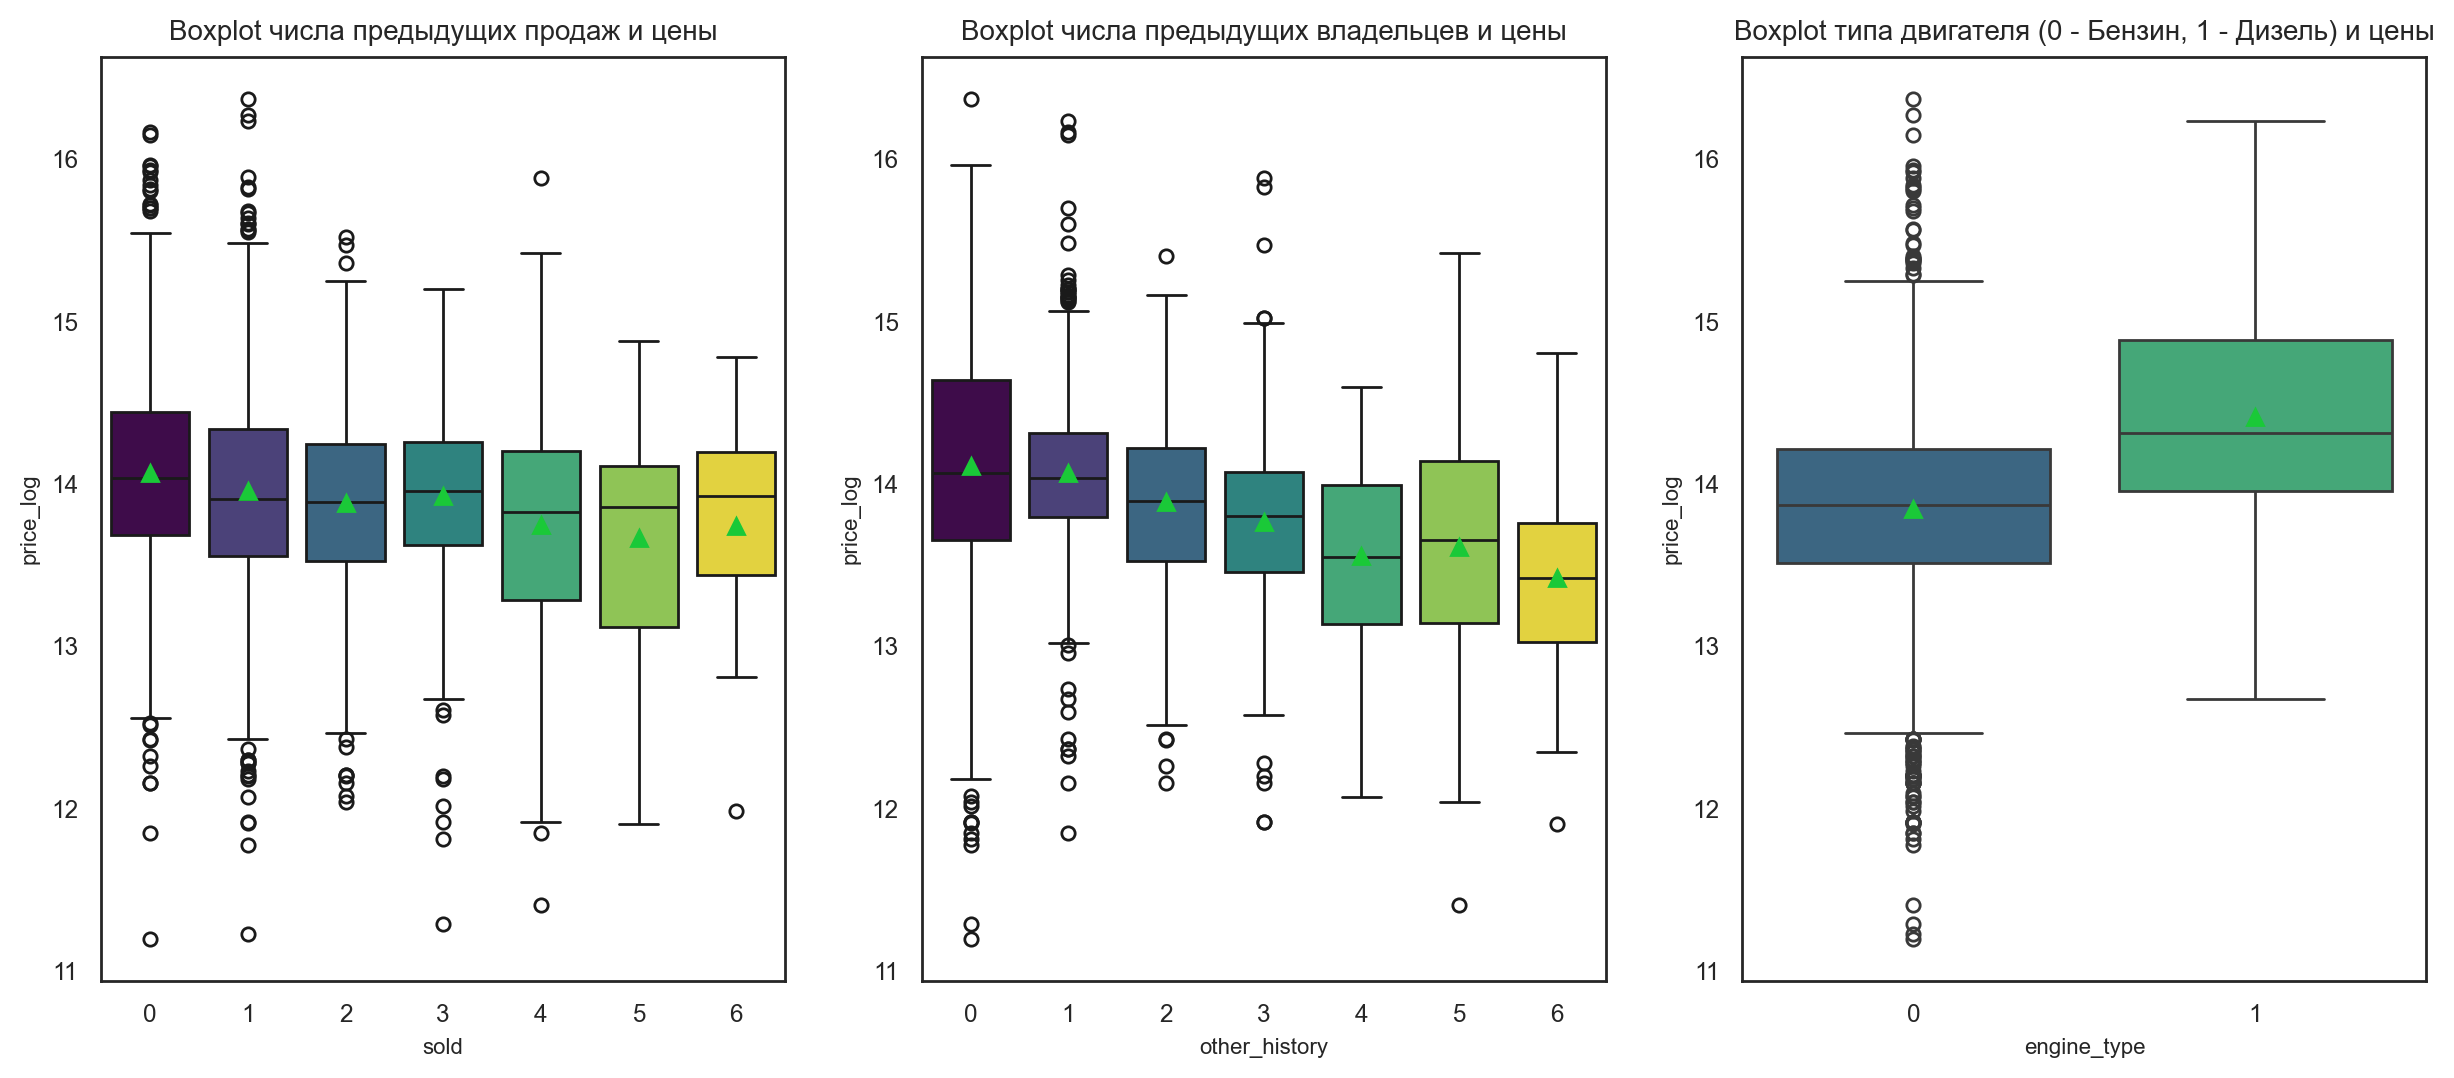

In [191]:
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes = axes.flatten()

sns.boxplot(x='sold', y='price_log', data=df[df['sold'] <= 6], showmeans=True, hue='sold', legend=False, ax=axes[0], palette='viridis')
axes[0].set_title('Boxplot числа предыдущих продаж и цены')

sns.boxplot(x='other_history', y='price_log', data=df[df['other_history'] <= 6], showmeans=True, hue='other_history', legend=False, ax=axes[1], palette='viridis')
axes[1].set_title('Boxplot числа предыдущих владельцев и цены')

sns.boxplot(x='engine_type', y='price_log', data=df, showmeans=True, hue='engine_type', legend=False, ax=axes[2], palette='viridis')
axes[2].set_title('Boxplot типа двигателя (0 - Бензин, 1 - Дизель) и цены')
plt.show()

Видим, что данные признаки распределены очень похожим образом, однако средние значения для числа предыдущих продаж ближе к 14, а значения для истории владельцев распределена сильнее. Также заметна очень небольшая отрицательная корреляция логарифма цены и рассматриваемых признаков, при этом цена сильнее уменьшается при росте числа владельцев, чем при увеличении числа предыдущих продаж на Авито.

**Промежуточные выводы исследования числовых и некоторыз категориальных признаков**

1. год выпуска и число лошадиных сил сильно положительно влияют на цену, то есть чем новее и мощнее автомобиль, его цена выше
2. Пробег, число предыдущих владельцев и продаж  отрицательно влияют на цену, т. е. чем "изношеннее" автомобиль его цена ниже

При этом цены распределены в определенном промежутке (до 4х миллионов)

Приступим к анализу связи цены и категориальных признаков

Для начала проанализируем связь между ценой и категориальными переменными с небольшим числом значений, а именно число владельцев по ПТС (owners_pts), тип привода (gear) и коробки передач (transmision), возможности обмена (exchange), соответствие цены и оценки Авито  (mark) и тип ПТС (pts_type). Для этого построим виолончели.

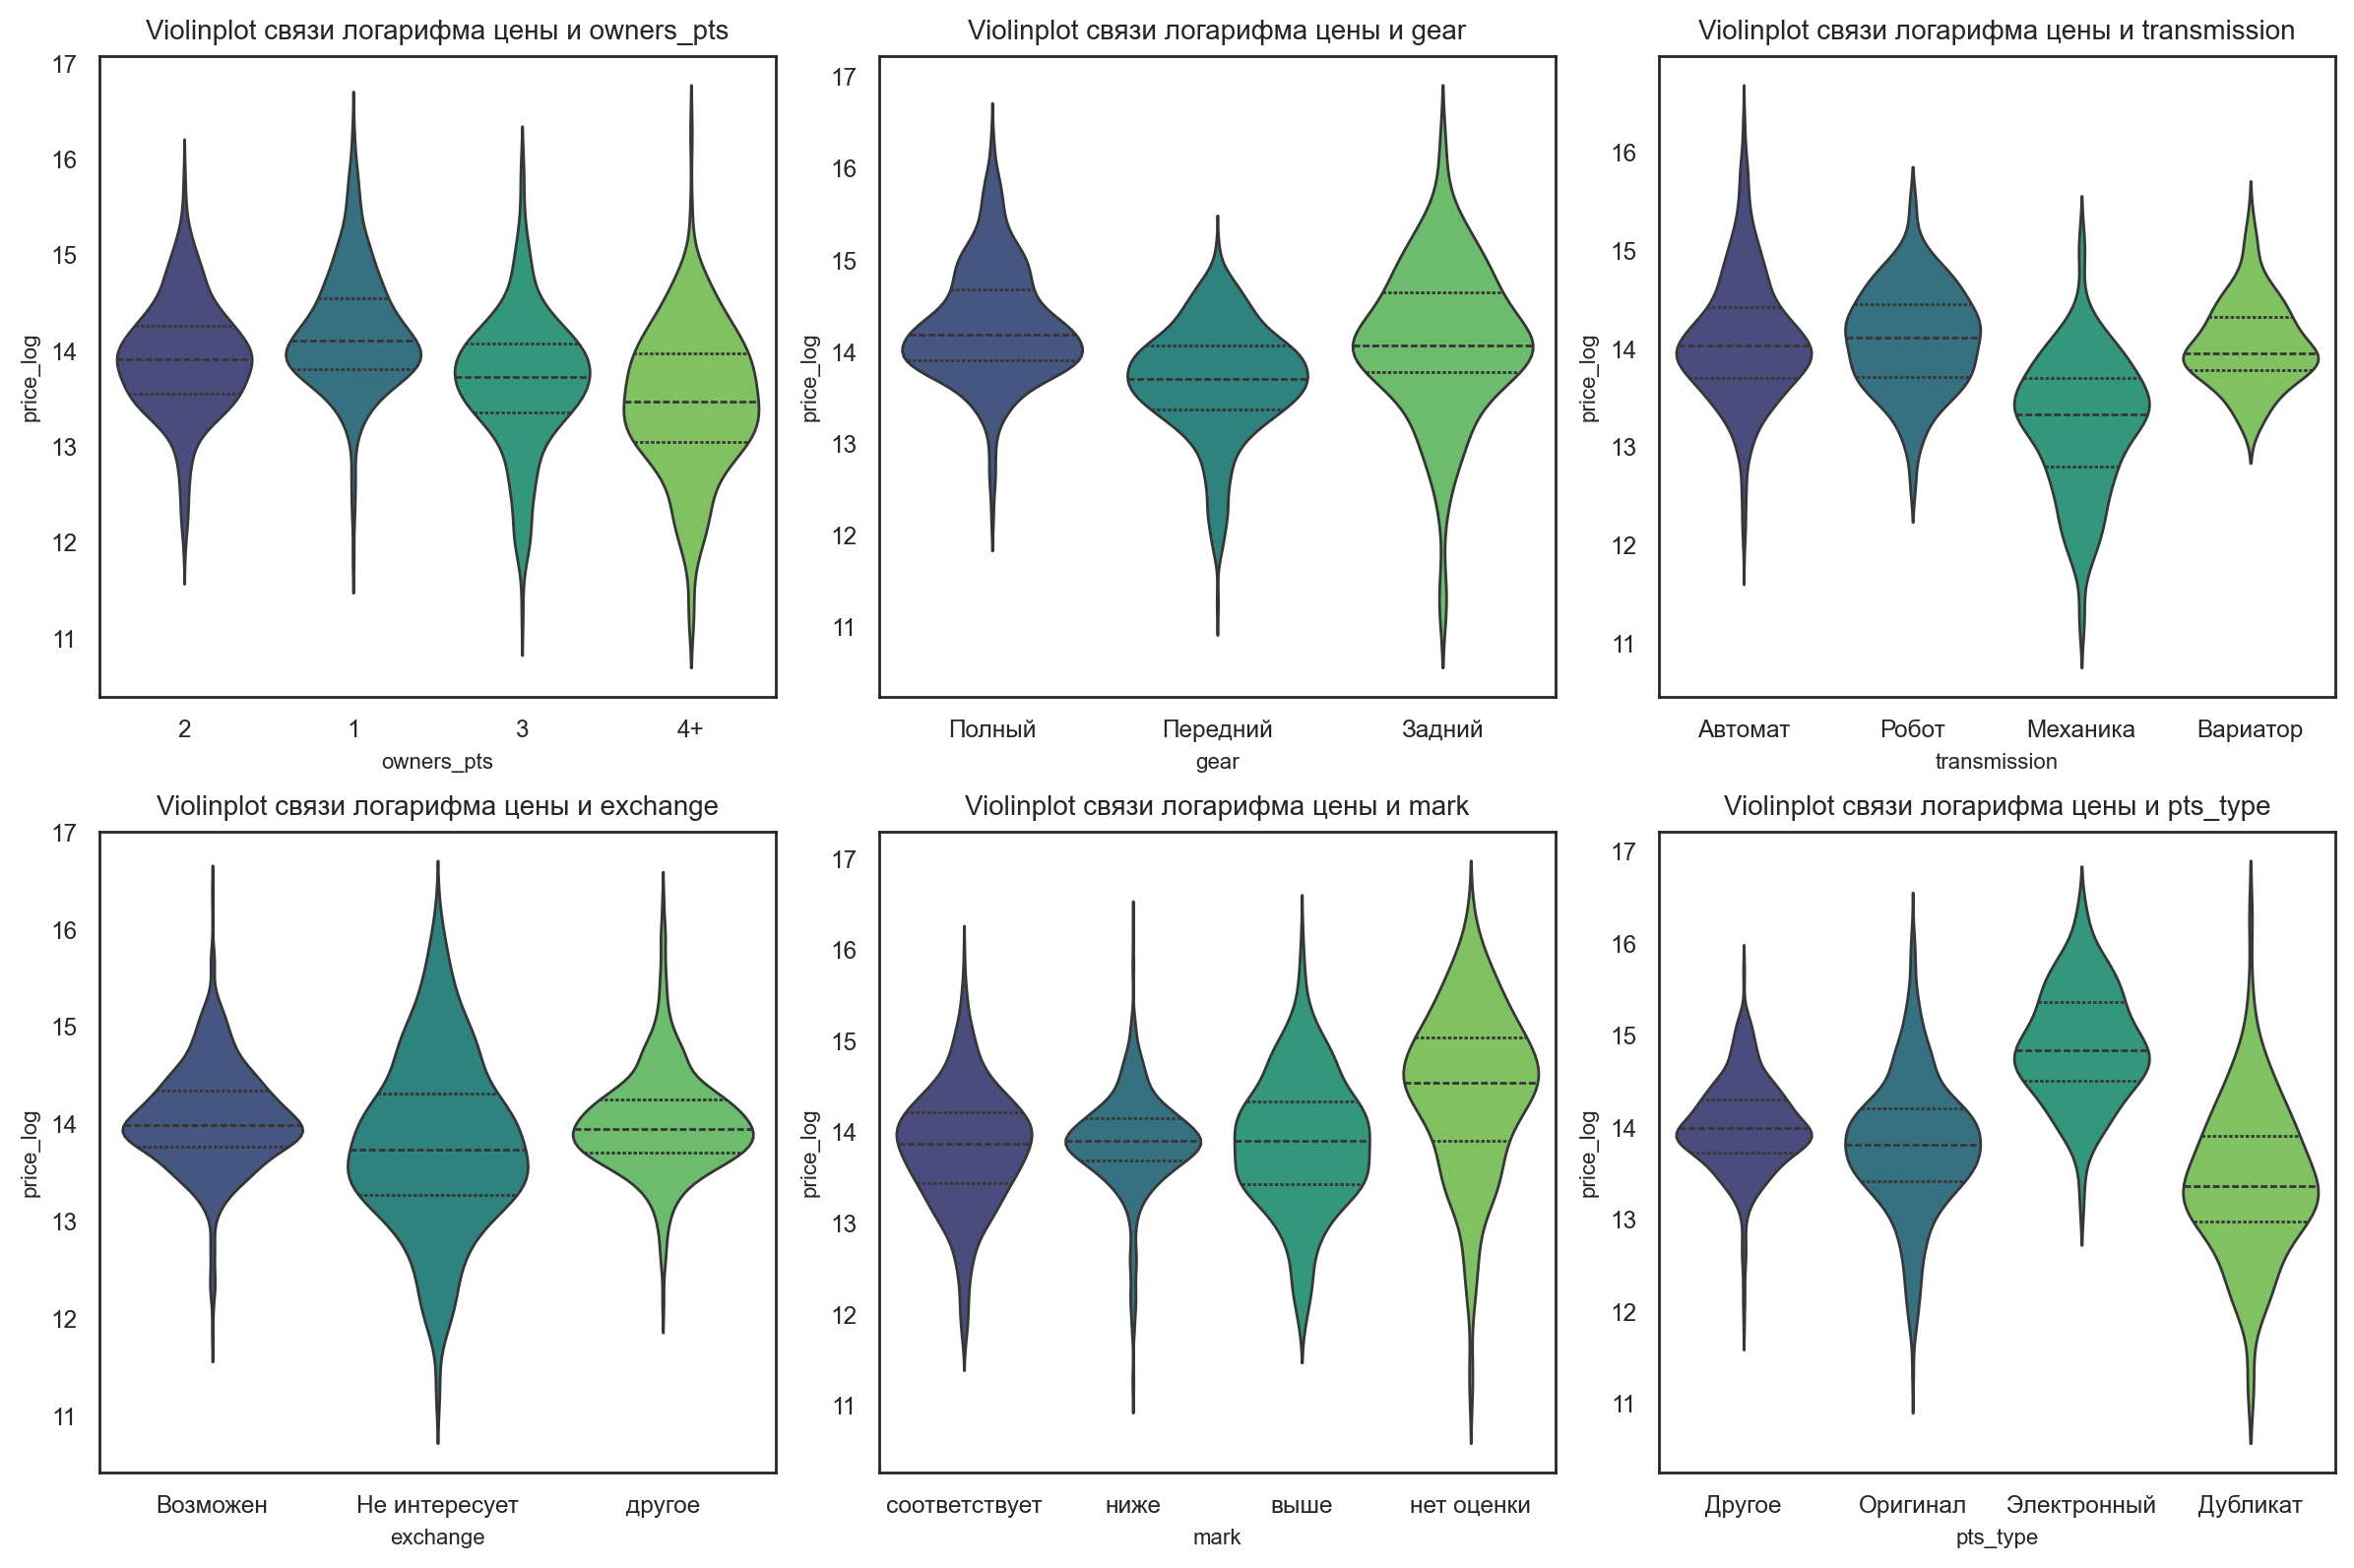

In [192]:
corr_cat_analisys_cols = ['owners_pts', 'gear', 'transmission', 'exchange', 'mark', 'pts_type']
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(corr_cat_analisys_cols):
    sns.violinplot(data=df, x=col, ax=axes[i], y='price_log',hue=col, legend=False, palette='viridis', inner='quartile') 
    axes[i].set_title(f'Violinplot связи логарифма цены и {col}') 
    

plt.tight_layout()
plt.show()

Видим что везде есть довольно сильный разброс значений, однако есть несколько небольших, выделяющихся корреляций:
- Цена ниже чем больше владельцев по ПТС (что соотносится с анализом числа владельцев на Авито и числом продаж)
- Машины с передним приводом и механической коробкой передач немного ниже в логарифме цены чем машины с полным и задним приводом и другими вариантами коробки передач
- Не очень релевантно смотреть на обмен и оценку от авито, так как там среднее отличается у категорий "нет оценки" (то есть отсутствия данных при парсинге) и Не интересует (которая сопоставима с категорией другое и не совсем интерпретируема)
- Большее различие имеет тип ПТС: машинны с Электронным дубликатом дороже (можно предположить, что они просто являются новее), а дубликат наоборот является понижающим значением для цены

Остаются переменные типа кузова, поколения и цвета, в которых более правильным будет посмотреть на самые большие категории.

<Figure size 1500x600 with 0 Axes>

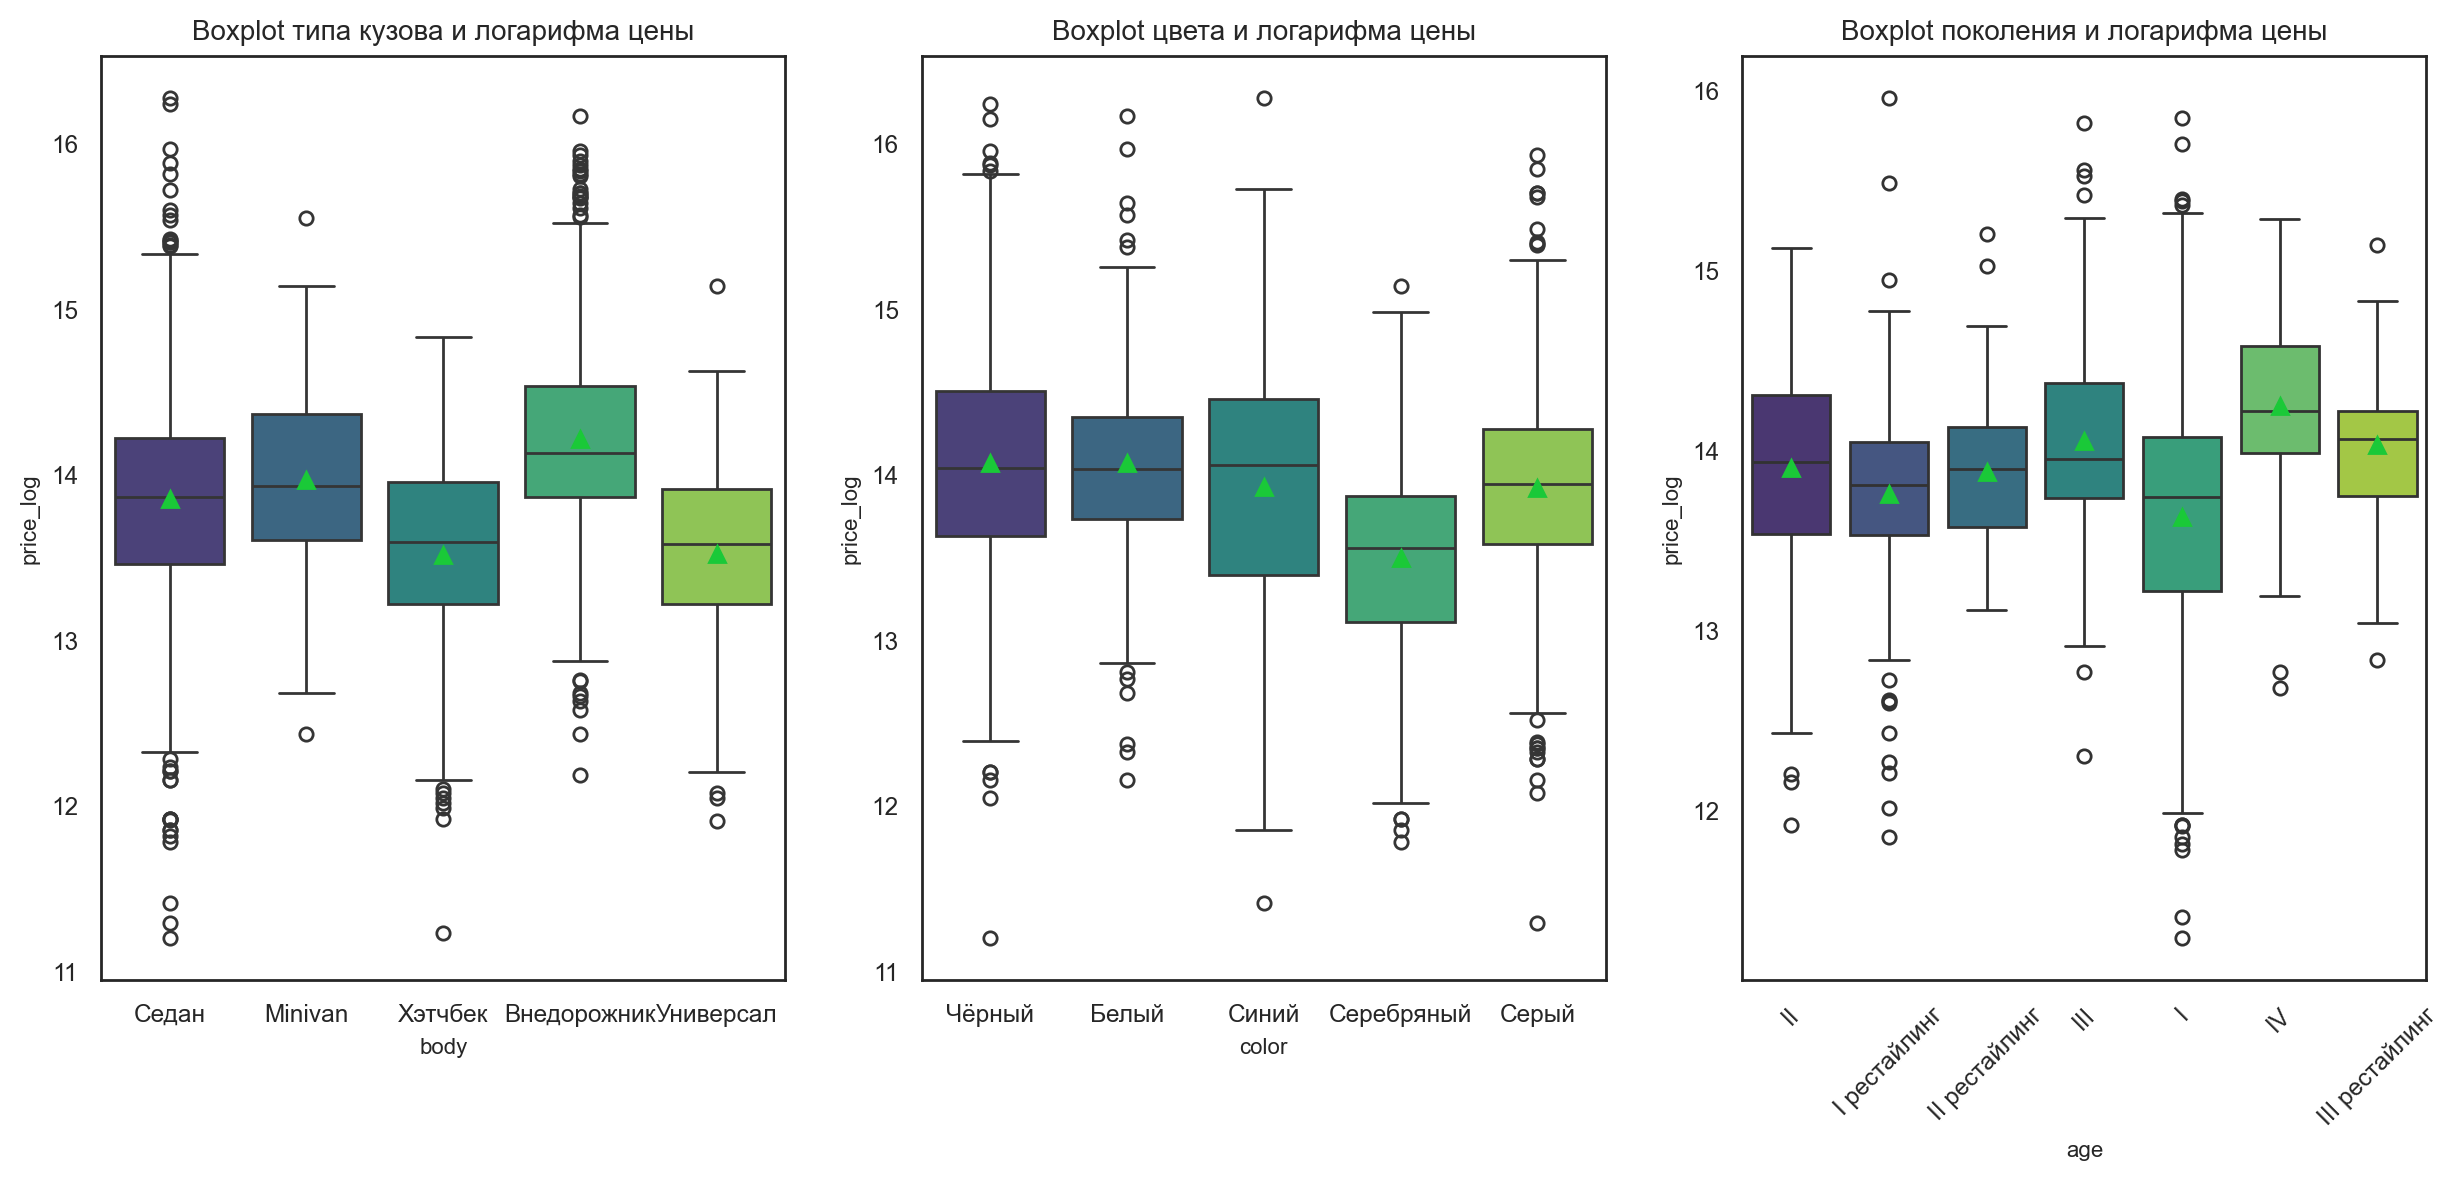

In [193]:
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes = axes.flatten()

sns.boxplot(x='body', y='price_log', data=df[df['body'].isin(df['body'].value_counts().nlargest(5).index)], showmeans=True, hue='body', legend=False, ax=axes[0], palette='viridis')
axes[0].set_title('Boxplot типа кузова и логарифма цены')

sns.boxplot(x='color', y='price_log', data=df[df['color'].isin(df['color'].value_counts().nlargest(5).index)], showmeans=True, hue='color', legend=False, ax=axes[1], palette='viridis')
axes[1].set_title('Boxplot цвета и логарифма цены')

sns.boxplot(x='age', y='price_log', data=df[df['age'].isin(df['age'].value_counts().nlargest(7).index)], showmeans=True, hue='age', legend=False, ax=axes[2], palette='viridis')
axes[2].set_title('Boxplot поколения и логарифма цены')
axes[2].tick_params(axis='x', labelrotation=45)
plt.show()

Из графиков выше в целом нельзя сказать о четкой закономерности. Хэтчебк и Универсал более дешевые модели, Внедорожник – дороже. Серебрянный цвет у более дешевых машин, однако явные зависимости не прослеживаются. Также можно сказать о том, что машины 1 поколения самая объемная категория со средней ценой чуть ниже остальных крупных категорий

#### Новые признаки

У нас остались не исследованные признаки – заголовок, модификация, поколение и список расстояний от метро и станций метро. Из данных переменных можно взять информацию об удаленности точни продажи до метро в целом, а также среднее время от предлагаемых станций метро. 

Из заголовка можно найти информацию о марке машины, а сама модификация скорее всего окажется бесполезным признаком с большим числом различных значений, который довольно тяжело интерпретировать и использовать в целом. 

Также вынесем флаг предыдущей продажи в отдельную переменную.


#### Гипотезы

(на момент промежуточного чекпоинта)

На данный момент хотелось бы понять, правда ли так незначительно влияют прошлые продажи и владельцы на цену
Возможно есть связь маленьких категорий багажника и цвета с ценой (так как по наблюдениям разноцветные машины обычно дороже)
Влияет ли марка X на цену (где X – марка которая будет выяснена в процессе формирования новой переменной)